# 0. Load Packages

In [21]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
#import h5py
from skimage import io,color
from os import walk
import os
import random
import tensorflow as tf
from datetime import datetime
from keras.models import model_from_json

# 1. Some Functions

In [78]:
#Convert RGB images to LAB using CIELAB, then return input X (L), target Y (A. B)
def rgbtolab_batch(path,row,column):
    X=[]
    Y=[]
    j=1
    for (dirpath,dirnames,filenames) in walk(path):
        for filename in filenames:
            if filename.endswith(".jpg")==True:
                # Get images
                image = img_to_array(load_img(dirpath+filename))
                image = np.array(image, dtype=float)
                if len(image[0]) == column or len(image) == row:
                    #print(j)
                    x = rgb2lab(1.0/255*image)[:,:,0]
                    y = rgb2lab(1.0/255*image)[:,:,1:]
                    y /= 128 #scale y
                    X.append(x)
                    Y.append(y)
                    j +=1
    return X,Y

def labtorgb_batch(l,a,b):
    rgb=[]
    for i in range(len(l)):
        lab=np.dstack([l[i],a[i],b[i]])
        img=color.lab2rgb(lab)
        rgb.append(img)

    return rgb

def showgray(path):
    for (dirpath,dirnames,filenames) in walk(path):
        for filename in filenames:
            rgb=io.imread(dirpath+filename,plugin='matplotlib')
            lab=color.rgb2lab(rgb)
            lab_copy=lab.copy()
            lab_copy[:,:,1]=0
            lab_copy[:,:,2]=0
            grey=color.lab2rgb(lab_copy)
            #plt.imsave(img[:-4]+'_gray.jpg',grey)
            plt.imshow(grey)
            plt.show()

def showRGB(img_list):
    for i in img_list:
        plt.imshow(i)
        plt.show()

def savePredict(img_list):
    for i in range(len(img_list)):
        plt.imsave("{}{}_predict{}.jpg".format(predict_path,i,datetime.today().strftime("%m%d%Y-%H%M%S")),img_list[i])

# 2. Some Paths

In [23]:
### Define column and row to find related folder
column=80
row=60

In [38]:
###Define Paths
path="images/"
folder = str(row)+"-"+str(column)
train_path=path+folder+"/train/"
test_path=path+folder+"/test/"
predict_path=path+folder+"/predict/"
model_path=path+folder+"/model/"

print("Training path: {}".format(train_path))
print("Testing path: {}".format(test_path))
print("Predict/Colorized path: {}".format(predict_path))
print("Model saved path: {}".format(model_path))

Training path: images/60-80/train/
Testing path: images/60-80/test/
Predict/Colorized path: images/60-80/predict/
Model saved path: images/60-80/model/


# 3. Data Processing and Reshaping

In [39]:
# Read training dataset
X,Y = rgbtolab_batch(train_path,row,column)

# Read testing dataset
X_test,Y_test = rgbtolab_batch(test_path,row,column)

# Define some parameters for sizes
n_sample=len(X)
n_test=len(X_test)
size=column*row

# Pre-process the data by reshaping
X=np.array(X)
Y=np.array(Y)
X = X.reshape(n_sample, row, column, 1)
Y = Y.reshape(n_sample, row, column, 2)

X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_test = X_test.reshape(n_test, row, column, 1)
Y_test = Y_test.reshape(n_test, row, column, 2)

print("{} images are loaded for training and validation.".format(n_sample))
print("{} images are loaded for testing.".format(n_test))
print("Images have a size of: {} * {}".format(row, column))

1000 images are loaded for training and validation.
6 images are loaded for testing.
Images have a size of: 60 * 80


In [53]:
#Some Hyperparameters
n=6 #kernal size
epoch=3 #epoch number
validation=0.005 #validation split
batch=10 #batch size

# 4. Build Model and Train

### Building the Convolutional Neural Network

In [54]:
model = Sequential()

model.add(Conv2D(16, (n, n), activation='relu', padding='same', input_shape=(row, column, 1)))
model.add(Conv2D(16, (n, n), activation='relu', padding='same'))
model.add(Conv2D(32, (n, n), activation='relu', padding='same'))
model.add(Conv2D(32, (n, n), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (n, n), activation='relu', padding='same'))
model.add(Conv2D(64, (n, n), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (n, n), activation='relu', padding='same'))
model.add(Conv2D(128, (n, n), activation='relu', padding='same'))
model.add(Conv2D(32, (n, n), activation='relu', padding='same'))
model.add(Conv2D(16, (n, n), activation='relu', padding='same'))
model.add(Conv2D(2, (n, n), activation='tanh', padding='same'))

### Finish model

In [55]:
# Compile model
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

In [56]:
# Fit model (training)
print("Training model on a validation split of {}, {} epochs, batch size of {}".format(validation, epoch, batch))
model.fit(X, Y, validation_split=validation, epochs=epoch, batch_size=batch)

Training model on a validation split of 0.005, 3 epochs, batch size of 10
Train on 995 samples, validate on 5 samples
Epoch 1/3
995/995 [==============================] - 447s 449ms/step - loss: 0.0626 - acc: 0.5571 - val_loss: 0.0078 - val_acc: 0.3601
Epoch 2/3
995/995 [==============================] - 435s 437ms/step - loss: 0.0128 - acc: 0.5843 - val_loss: 0.0079 - val_acc: 0.6983
Epoch 3/3
995/995 [==============================] - 445s 448ms/step - loss: 0.0127 - acc: 0.5876 - val_loss: 0.0080 - val_acc: 0.6983


In [57]:
# Evaluate the trained model on test batch
model.evaluate(X_test,Y_test,batch_size=10)

6/6 [==============================] - 1s 113ms/step


[0.006595567334443331, 0.4542014002799988]

In [58]:
# Predict RGB
Y_predict=model.predict(X_test)

# 5. Process output data and show/save colorized images

In [59]:
# Process the predicted data by reshaping to displayable RGB
Y_predict *=128
Y_a=Y_predict[:,:,:,0].reshape(n_test,row,column,1)
Y_b=Y_predict[:,:,:,1].reshape(n_test,row,column,1)
Y_ori_a=Y_test[:,:,:,0].reshape(n_test,row,column,1)*128
Y_ori_b=Y_test[:,:,:,1].reshape(n_test,row,column,1)*128
rgb_list=labtorgb_batch(X_test,Y_a,Y_b)
rgb_original=labtorgb_batch(X_test,Y_ori_a,Y_ori_b)

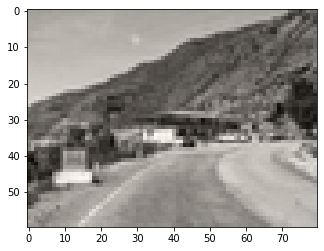

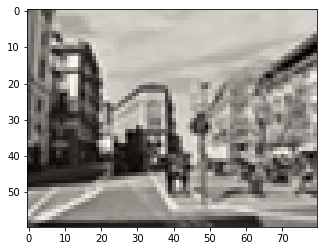

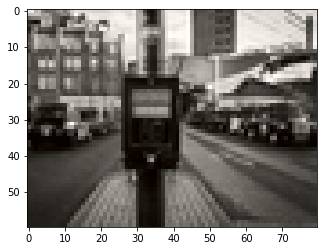

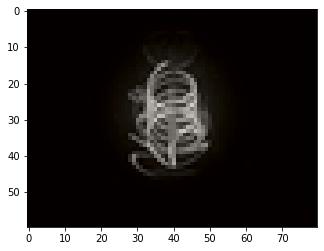

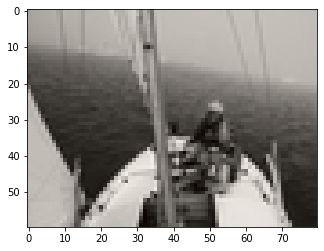

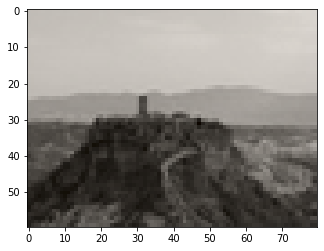

In [60]:
showRGB(rgb_list)

In [ ]:
#showRGB(rgb_original)

In [79]:
savePredict(rgb_list)

In [ ]:
#grey_original=showgray(test_path)

# 6. Save Model and Weights

In [ ]:
model_json=model.to_json()

with open("{}model_{}.json".format(predict_path,datetime.today().strftime('%y%m%d-%h%m%s')),"w") as json_file:
    json_file.write(model_json)

model.save_weights("{}model_{}.h5".format(predict_path,datetime.today().strftime('%y%m%d-%h%m%s')))
